In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout,Dense,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16


Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
#load the data

training_set = pd.read_csv('fashion-mnist_train.csv')
testing_set = pd.read_csv('fashion-mnist_test.csv')



In [4]:
#Preprocess the data 
# Reshape the given csv into the original images


# pixels values for each image
X_train = np.array(training_set.iloc[:,1:])
X_test = np.array(testing_set.iloc[:,1:])

X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')

X_train = X_train/255
X_test = X_test/255

#label for each image
target = training_set.iloc[:,0]
y_train = to_categorical(np.array(training_set.iloc[:,0])) 
y_test = to_categorical(np.array(testing_set.iloc[:,0]))

In [ ]:
# Prepare data for transfer learning
import skimage
from skimage.transform import resize
#X_train = np.array([misc.imresize(x, (48,48)).astype(float) for x in np.nditer(X_train)]).
X_train_bis = np.zeros((X_train.shape[0],48,48,1))
#X_train_bis = []
#for x in np.nditer(X_train) :
    #X_train_bis.append(np.array(skimage.transform.resize(x, (48,48)).astype(float)) )

for x in X_train: 
    im = skimage.transform.resize(x, (48,48))
    np.append(X_train_bis,im)


C:\Users\Dalila\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
# Building a cnn model based on VGG model -> Transfer learning

from keras import backend as K
from keras.layers import Lambda, Input
from keras.models import Model

                    
number_of_classes = y_test.shape[1]
input_image = Input(shape=(48,48))
inputs = Lambda(lambda x: K.repeat_elements(K.expand_dims(x,3),3,3))(input_image)
vgg = VGG16(weights = "imagenet", include_top=False, input_tensor = inputs,pooling='max', classes=number_of_classes)
#vgg.summary()

for layer in vgg.layers[:17]:
    layer.trainable = False

x = vgg.output
#x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(number_of_classes, activation="softmax")(x)

# creating the final model 
final_model = Model(inputs = vgg.input, outputs = predictions)


In [ ]:
# Displaying the final model
final_model.summary()

In [ ]:
# Training the model
batch_size = 150
epochs = 5
#model = create_model()
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = final_model.fit(X_train_bis, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
validation_data=(X_test, y_test))

In [22]:
# Evaluate the model 
score = final_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.226422051327
Test accuracy: 0.925


In [23]:
# Make predictions about the classes
predictions = model.predict_classes(X_test,batch_size=150)  


In [10]:
# Save the classification

filename = 'cnn_classification4.csv';
PictureID = list(range(1,len(predictions)+1))
submission = pd.DataFrame({'Clothe_category':predictions })
submission.to_csv(filename,header = True, index = False)
print('Saved file: ' + filename)

Saved file: cnn_classification4.csv


In [24]:
# Data Model visualization
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 20, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          51264     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 2, 64)          102464    
__________

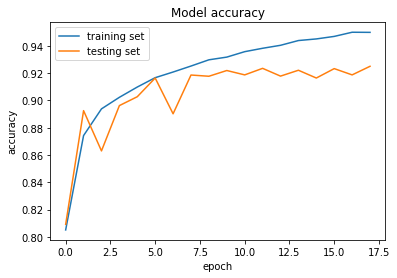

In [25]:
# Accuracy visualization
training_accuracy = history.history['acc']
testing_accuracy = history.history['val_acc']
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.title('Model accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

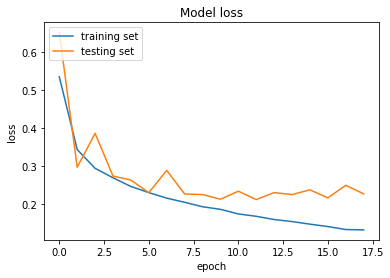

In [26]:
# Loss visualization

training_loss = history.history['loss']
testing_loss = history.history['val_loss']
plt.plot(training_loss)
plt.plot(testing_loss)
plt.title('Model loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()
